In [1]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

from scipy import stats
from scipy.integrate import quad

import pickle

# Data

In [2]:
#data_filename = 'data_flags_updated_Nov1.dat'
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

#catalog_SDSS = Table.read(data_filename, format='ascii')
hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [3]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

## Identify which fields are being used for which parameters

In [5]:
catalog_main.colnames

['IAUNAME',
 'SUBDIR',
 'RA',
 'DEC',
 'ISDSS',
 'INED',
 'ISIXDF',
 'IALFALFA',
 'IZCAT',
 'ITWODF',
 'MAG',
 'Z',
 'ZSRC',
 'SIZE',
 'RUN',
 'CAMCOL',
 'FIELD',
 'RERUN',
 'XPOS',
 'YPOS',
 'NSAID',
 'ZDIST',
 'SERSIC_NMGY',
 'SERSIC_NMGY_IVAR',
 'SERSIC_OK',
 'SERSIC_RNMGY',
 'SERSIC_ABSMAG',
 'SERSIC_AMIVAR',
 'EXTINCTION',
 'SERSIC_KCORRECT',
 'SERSIC_KCOEFF',
 'SERSIC_MTOL',
 'SERSIC_B300',
 'SERSIC_B1000',
 'SERSIC_METS',
 'SERSIC_MASS',
 'XCEN',
 'YCEN',
 'NPROF',
 'PROFMEAN',
 'PROFMEAN_IVAR',
 'QSTOKES',
 'USTOKES',
 'BASTOKES',
 'PHISTOKES',
 'PETRO_FLUX',
 'PETRO_FLUX_IVAR',
 'FIBER_FLUX',
 'FIBER_FLUX_IVAR',
 'PETRO_BA50',
 'PETRO_PHI50',
 'PETRO_BA90',
 'PETRO_PHI90',
 'SERSIC_FLUX',
 'SERSIC_FLUX_IVAR',
 'SERSIC_N',
 'SERSIC_BA',
 'SERSIC_PHI',
 'ASYMMETRY',
 'CLUMPY',
 'DFLAGS',
 'AID',
 'PID',
 'DVERSION',
 'PROFTHETA',
 'PETRO_THETA',
 'PETRO_TH50',
 'PETRO_TH90',
 'SERSIC_TH50',
 'PLATE',
 'FIBERID',
 'MJD',
 'RACAT',
 'DECCAT',
 'ZSDSSLINE',
 'SURVEY',
 'PROGRAMNAME

In [4]:
# ra,dec,z
ra = np.array(catalog_main['RA']) #np.array(data['ra'])
dec = np.array(catalog_main['DEC']) #np.array(data['dec'])
z = np.array(catalog_main['Z']) #np.array(data['redshift'])

# stellar mass
#Mstar = np.array(data['Mstar'])
# Mstar = Mstar[np.logical_not(np.isnan(Mstar))] 
Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS']) #np.array(data['Mstar_NSA'])

# color
u_r = np.array(catalog_main['u_r_KIAS']) #np.array(data['u_r'])
# u_r = u_r[np.logical_not(np.isnan(u_r))]
u_r_NSA = np.array(catalog_main['u_r']) #np.array(data['u_r_NSA'])
#g_r = np.array(data['g_r'])
# g_r = g_r[np.logical_not(np.isnan(g_r))] 
g_r_NSA = np.array(catalog_main['g_r']) #np.array(data['g_r_NSA'])

# absolute magnitude
#rabsmag = np.array(data['rabsmag'])
# rabsmag = rabsmag[np.logical_not(np.isnan(rabsmag))] 
rabsmag_NSA = np.array(catalog_main['ELPETRO_ABSMAG'][:,4]) #np.array(data['rabsmag_NSA'])

#star formation rate and specific SPR
SFR  = np.array(catalog_main['SFR']) #np.array(data['SFR'])
# SFR = SFR[np.logical_not(np.isnan(SFR))] 
sSFR = np.array(catalog_main['sSFR']) #np.array(data['sSFR'])
# sSFR = sSFR[np.logical_not(np.isnan(sSFR))]

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_3252/912260125.py:9: RuntimeWarning: divide by zero encountered in log10
  Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS']) #np.array(data['Mstar_NSA'])


## Separate galaxies by their LSS classifications

### $V^2$

In [5]:
wall_v2 = catalog_main['vflag_V2'] == 0 #np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = catalog_main['vflag_V2'] == 1 #np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = catalog_main['vflag_V2'] == 2 #np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = catalog_main['vflag_V2'] == 9 #np.argwhere(data['flag_vsquared'] == 9).flatten()

### VoidFinder

In [6]:
wall_vf = catalog_main['vflag_VF'] == 0 #np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = catalog_main['vflag_VF'] == 1 #np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = catalog_main['vflag_VF'] == 2 #np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = catalog_main['vflag_VF'] == 9 #np.argwhere(data['flag_voidfinder'] == 9).flatten()

# Result plots

In [7]:
def char_void(char_, bins_, title='galaxy property', label='x-label'):
    '''
    Plots a histogram for a galaxy characterstic for void galaxies only 
    for both algorithms
    
    PARAMETERS
    ==========
    
    char_ : (numpy array)
        charachteristic of galaxy desired for plotting
    
    bins_ : (numpy linear space) 
        histogram bins
    '''
    char_void_vf = char_[void_vf]
    char_void_v2 = char_[void_v2]
    
    fig, ax = plt.subplots(figsize=(10, 6)) # 8,4
    
#     plt.hist(char_void_vf, label = 'Voidfinder void galaxies' ,bins= bins_,alpha = 0.6, density = True, color='green')
#     plt.hist(char_void,  label = 'V^2 void galaxies',bins= bins_, color = 'blue',alpha = 0.4, density = True)
#     plt.hist(char_[data['redshift']< 0.1026],  label = 'All galaxies',bins= bins_, color = 'gray',alpha = 0.6, density = True)

#     plt.legend()
#     plt.title(title)
#     plt.xlabel(label)    
    
#     plt.savefig('figures/'+title+".png")
#     plt.show()
    
    
    counts_void_vf, bins_void_vf = np.histogram(char_void_vf, bins= bins_)
    counts_void_v2, bins_void_v2 = np.histogram(char_void_v2, bins= bins_)
    counts_all, bins_all = np.histogram(char_[catalog_main['Z']< 0.114], bins= bins_)
    
    counts_void_vf = np.array(counts_void_vf)/len(char_void_vf)
    counts_void_v2 = np.array(counts_void_v2)/len(char_void_v2)
    counts_all = np.array(counts_all)/len(char_[catalog_main['Z']< 0.114])
    
    ax.hist(bins_void_vf[:-1], 
            bins=bins_void_vf, 
            weights=counts_void_vf, 
            label = 'Voidfinder void galaxies' , 
            color='red', 
            histtype='step')
    ax.hist(bins_void_v2[:-1], 
            bins=bins_void_v2, 
            weights=counts_void_v2,
            label = r'$V^{2}$ void galaxies', 
            color = 'blue',
            histtype='step')
    ax.hist(bins_all[:-1], 
            bins=bins_all, 
            weights=counts_all, 
            label = 'All', 
            color = 'gray',
            alpha = 0.2)
    
    
    ax.legend(fontsize=14)
#     plt.title(title, fontsize=18)
    ax.set_xlabel(label, fontsize=20)
    ax.set_ylabel(r"Fraction of galaxies", fontsize=20)
    
    if label == 'Absolute Magnitude' or label == 'Absolute Magnitude - NSA':
        ax.set_xlim(-12, -24) 
        
#     plt.savefig('figures/'+title+".png")
#     plt.show()

In [8]:
def char(char_, 
         bins_, 
         title='galaxy property', 
         label='x-label', 
         voidfinder=False,
         x=None,
         y=None):
    '''
    Plots a histogram for a galaxy characterstic for wall and void galaxies
    
    PARAMETERS
    ==========
    
    char_ : (numpy array)
        charachteristic of galaxy desired for plotting
    
    bins_ : (numpy linear space)
        histogram bins
    
    voidfinder : (bool) 
        True if the classification comes from the VoidFinder algorithm, 
        False if it comes from V^2
    
    x : 
        x coordinate of the location of the algorithm's name
    
    y :
        y coordinate of the location of the algorithm's name
    '''
    
    if voidfinder:
        char_wall = char_[wall_vf]
        char_void = char_[void_vf]
#         char_edge = char_[edge_vf]
#         char_out = char_[out_vf]
        x_vf=x
        y_vf=y
    else:
        char_wall = char_[wall_v2]
        char_void = char_[void_v2]
#         char_edge = char_[edge_v2]
#         char_out = char_[out_v2]
        x_v2=x
        y_v2=y
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.tick_params(labelsize=20)
    
    counts_wall, bins_wall = np.histogram(char_wall, bins= bins_)
    counts_void, bins_void = np.histogram(char_void, bins= bins_)
    
#     counts_edge, bins_edge = np.histogram(char_edge, bins= bins_)
#     counts_out, bins_out = np.histogram(char_out, bins= bins_)
    
    counts_all, bins_all = np.histogram(char_[catalog_main['Z']< 0.114], 
                                        bins= bins_)
    
    
    counts_wall = np.array(counts_wall)/len(char_wall)
    counts_void = np.array(counts_void)/len(char_void)
#     counts_edge, counts_out = np.array(counts_edge)/len(char_edge), np.array(counts_out)/len(char_out)
    counts_all = np.array(counts_all)/len(char_[catalog_main['Z']< 0.114])
    
    '''
    if voidfinder:
        color_wall='black'
        color_void='red'
    else:
        color_wall='blue'
        color_void='green'
    '''
    color_wall = 'black'
    color_void = 'red'
    
    ax.hist(bins_void[:-1], 
            bins=bins_void, 
            weights=counts_void ,
            label = 'Void', 
            color = color_void,
            histtype='step', 
            linewidth=2)
    ax.hist(bins_wall[:-1], 
            bins=bins_wall, 
            weights=counts_wall, 
            label = 'Wall' , 
            color=color_wall, 
            histtype='step',
            linestyle='dotted', 
            linewidth=2)
    
#     ax.hist(bins_edge[:-1], bins=bins_edge, weights=counts_edge ,label = 'Edge', color = 'green',histtype='step')
#     ax.hist(bins_out[:-1], bins=bins_out, weights=counts_out ,label = 'Out', color = 'purple',histtype='step')

    ax.hist(bins_all[:-1], 
            bins=bins_all, 
            weights=counts_all,  
            label = 'All', 
            color = 'gainsboro', 
            ec='gainsboro')
    
#     if (voidfinder == True) & (x!= None):
#         ax.text(x_vf, y_vf, "VoidFinder", fontsize=20)
#     if (voidfinder == False) & (x!= None):
#         ax.text(x_v2, y_v2, r'\boldmath$V^{2}$', fontsize=20)
    
    ax.legend(fontsize=18)
    ax.set_xlabel(label, fontsize=24)
    ax.set_ylabel("Fraction of galaxies", fontsize=24)
    
#     plt.title(title, fontsize=18)
    if voidfinder:
        ax.set_title('VoidFinder', fontsize=24)
    else:
        ax.set_title('$V^2$', fontsize=24)
    
    if label in ['Absolute Magnitude', 'Absolute Magnitude - NSA', '$M_r$']:
        ax.set_xlim(-12, -24)
        
    plt.tight_layout()
    
    plt.savefig('figures/'+title+".eps", format='eps', dpi=300)
#     plt.show()

In [9]:
def char_unnorm(char_, 
                bins_, 
                title='galaxy property', 
                label='x-label', 
                voidfinder=False,
                x=None,
                y=None):
    '''
    Plots an unnormalized histogram for a galaxy characterstic for wall and void galaxies
    
    PARAMETERS
    ==========
    
    char_ : (numpy array)
        charachteristic of galaxy desired for plotting
    
    bins_ : (numpy linear space)
        histogram bins
    
    voidfinder : (bool) 
        True if the classification comes from the VoidFinder algorithm, 
        False if it comes from V^2
    
    x : 
        x coordinate of the location of the algorithm's name
    
    y :
        y coordinate of the location of the algorithm's name
    '''
    
    if voidfinder:
        char_wall = char_[wall_vf]
        char_void = char_[void_vf]
#         char_edge = char_[edge_vf]
#         char_out = char_[out_vf]
        x_vf=x
        y_vf=y
    else:
        char_wall = char_[wall_v2]
        char_void = char_[void_v2]
#         char_edge = char_[edge_v2]
#         char_out = char_[out_v2]
        x_v2=x
        y_v2=y
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.tick_params(labelsize=20)
    
    counts_wall, bins_wall = np.histogram(char_wall, bins= bins_)
    counts_void, bins_void = np.histogram(char_void, bins= bins_)
    
#     counts_edge, bins_edge = np.histogram(char_edge, bins= bins_)
#     counts_out, bins_out = np.histogram(char_out, bins= bins_)
    
    counts_all, bins_all = np.histogram(char_[catalog_main['Z']< 0.114], 
                                        bins= bins_)
    
    '''
    counts_wall = np.array(counts_wall)/len(char_wall)
    counts_void = np.array(counts_void)/len(char_void)
#     counts_edge, counts_out = np.array(counts_edge)/len(char_edge), np.array(counts_out)/len(char_out)
    counts_all = np.array(counts_all)/len(char_[catalog_main['Z']< 0.114])
    '''
    '''
    if voidfinder:
        color_wall='black'
        color_void='red'
    else:
        color_wall='blue'
        color_void='green'
    '''
    color_wall = 'black'
    color_void = 'red'
    
    ax.hist(bins_void[:-1], 
            bins=bins_void, 
            weights=counts_void ,
            label = 'Void', 
            color = color_void,
            histtype='step', 
            linewidth=2)
    ax.hist(bins_wall[:-1], 
            bins=bins_wall, 
            weights=counts_wall, 
            label = 'Wall' , 
            color=color_wall, 
            histtype='step',
            linestyle='dotted', 
            linewidth=2)
    
#     ax.hist(bins_edge[:-1], bins=bins_edge, weights=counts_edge ,label = 'Edge', color = 'green',histtype='step')
#     ax.hist(bins_out[:-1], bins=bins_out, weights=counts_out ,label = 'Out', color = 'purple',histtype='step')

    ax.hist(bins_all[:-1], 
            bins=bins_all, 
            weights=counts_all,  
            label = 'All', 
            color = 'gainsboro', 
            ec='gainsboro')
    
#     if (voidfinder == True) & (x!= None):
#         ax.text(x_vf, y_vf, "VoidFinder", fontsize=20)
#     if (voidfinder == False) & (x!= None):
#         ax.text(x_v2, y_v2, r'\boldmath$V^{2}$', fontsize=20)
    
    ax.legend(fontsize=18)
    ax.set_xlabel(label, fontsize=24)
    ax.set_ylabel("Number of galaxies", fontsize=24)
    
#     plt.title(title, fontsize=18)
    if voidfinder:
        ax.set_title('VoidFinder', fontsize=24)
    else:
        ax.set_title('$V^2$', fontsize=24)
    
    if label in ['Absolute Magnitude', 'Absolute Magnitude - NSA', '$M_r$']:
        ax.set_xlim(-12, -24)
        
    plt.tight_layout()
    
#     plt.savefig('figures/'+title+"_unnorm.eps", format='eps', dpi=300)
#     plt.show()

## Stellar mass

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


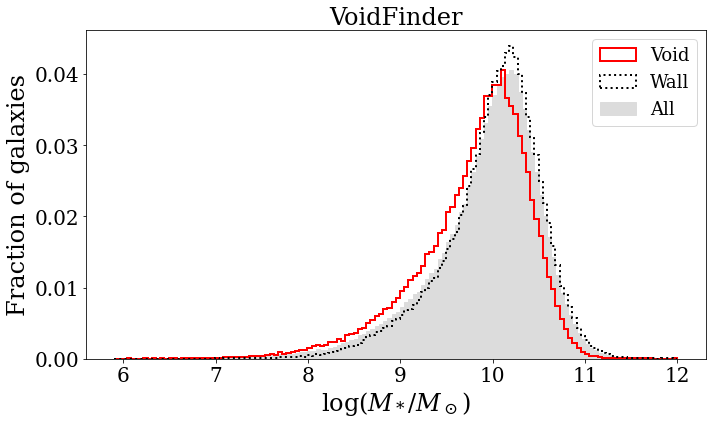

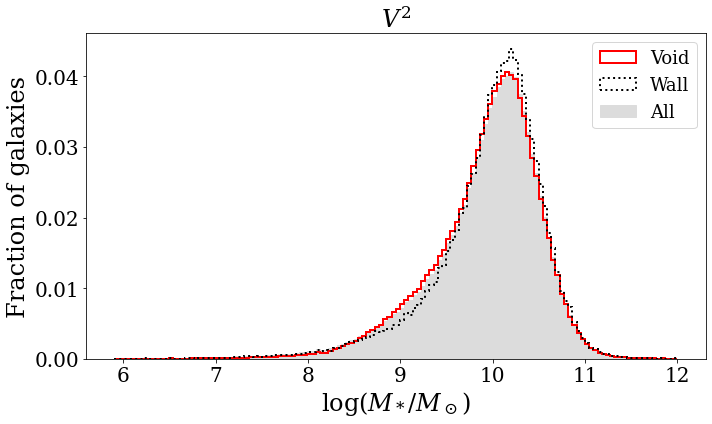

In [10]:
char(Mstar_NSA,
     np.linspace(5.9,12, 135),
     'Mstar_hist_VF_NSA',
     r'$\log(M_*/M_\odot)$',
     voidfinder=True,
     x=6,
     y=0.025)

char(Mstar_NSA,
     np.linspace(5.9,12, 135),
     'Mstar_hist_V2_NSA',
     r'$\log(M_*/M_\odot)$',
     x=6,
     y=0.025)

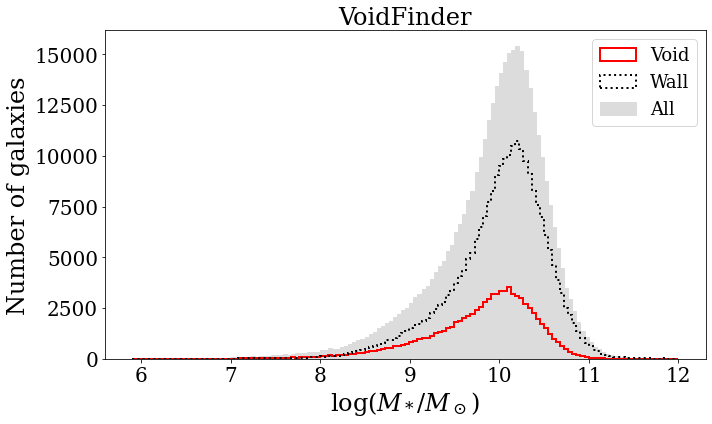

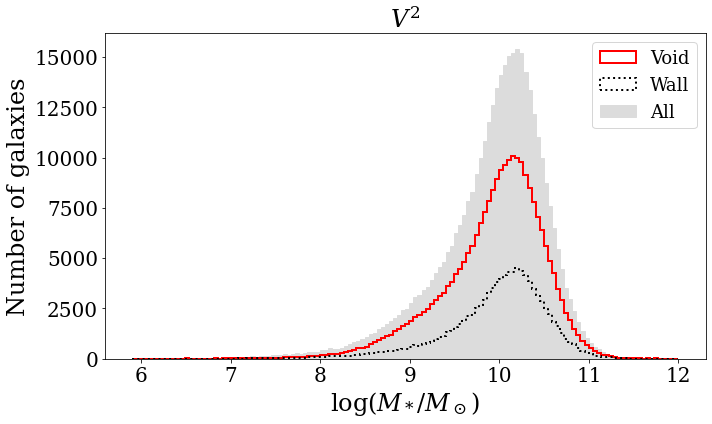

In [11]:
char_unnorm(Mstar_NSA,
            np.linspace(5.9,12, 135),
            'Mstar_hist_VF_NSA',
            r'$\log(M_*/M_\odot)$',
            voidfinder=True,
            x=6,
            y=0.025)

char_unnorm(Mstar_NSA,
            np.linspace(5.9,12, 135),
            'Mstar_hist_V2_NSA',
            r'$\log(M_*/M_\odot)$',
            x=6,
            y=0.025)

## Color

### $u-r$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


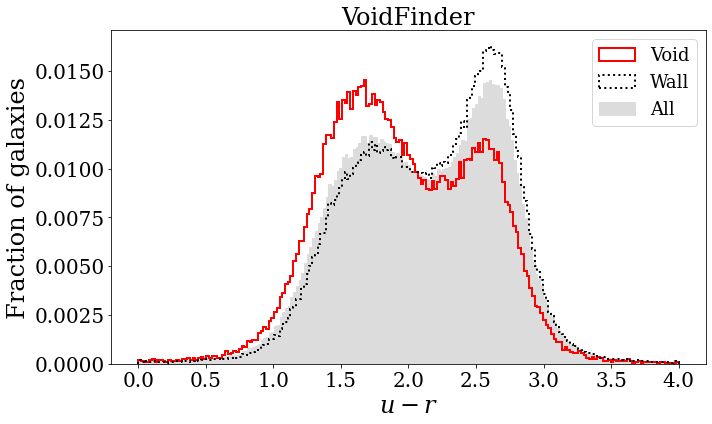

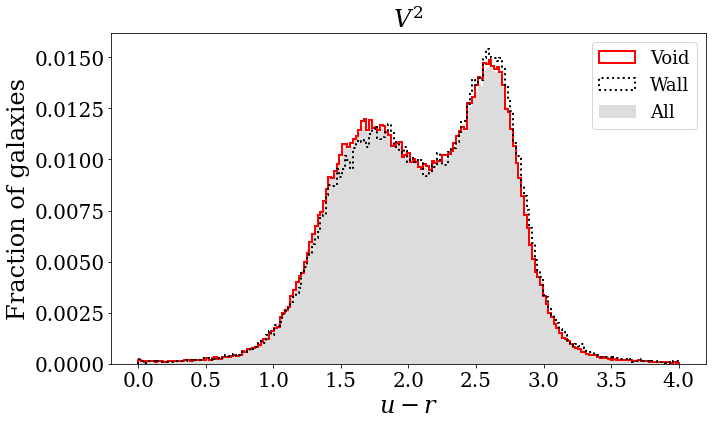

In [12]:
char(u_r_NSA, 
     np.linspace(0,4, 200),
     'u-r_hist_VF_NSA',
     r'$u-r$', 
     voidfinder = True,
     x=0.2,
     y=0.016)

char(u_r_NSA, 
     np.linspace(0,4, 200),
     'u-r_hist_V2_NSA',
     r'$u-r$', 
     x=0.2,
     y=0.016)

#### Color u-r - NSA

The conclusions from VF are in line with the literature that indicates that void galaxies are retarded in their star formation because they evolve in an environment with fewer interactions (mergers, tidal stripping etc) compared to wall galaxies.

$V^2$ does not make the same prediction because it grows voids farther into the walls which leads to the contamination of the classification

### $g-r$ 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


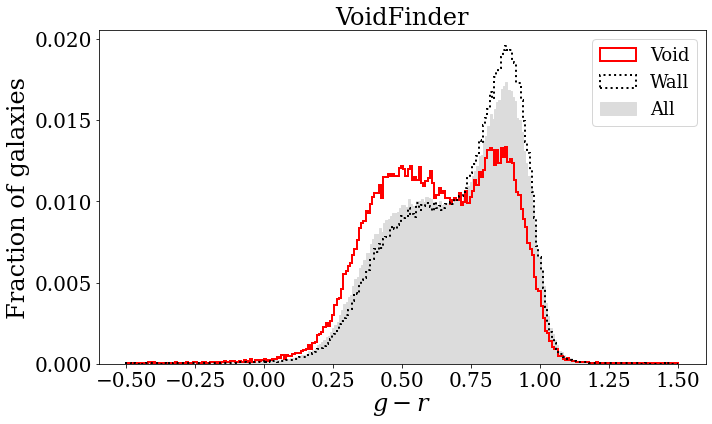

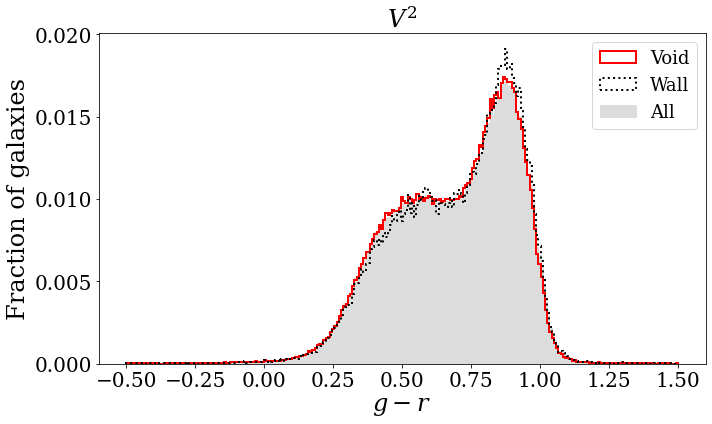

In [13]:
char(g_r_NSA, 
     np.linspace(-0.5,1.5, 250),
     'g-r_hist_VF_NSA',
     r'$g-r$', 
     voidfinder = True,
     x=0.2,
     y=0.016)

char(g_r_NSA, 
     np.linspace(-0.5,1.5, 250),
     'g-r_hist_V2_NSA',
     r'$g-r$', 
     x=0.2,
     y=0.016)

## Absolute magnitude

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


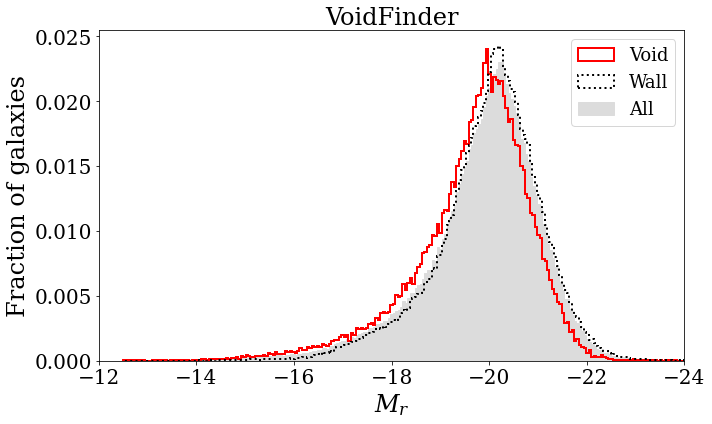

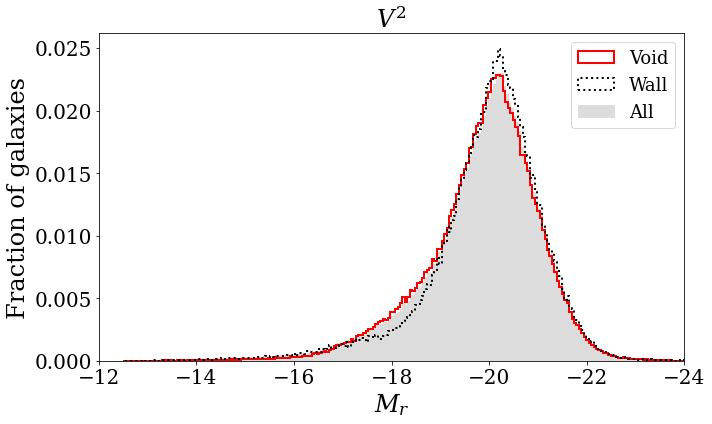

In [14]:
char(rabsmag_NSA,
     np.linspace(-25,-12.5, 250),
     'rabsmag_hist_VF_NSA',
     '$M_r$', 
     voidfinder=True,
     x=-13,
     y=0.023)

char(rabsmag_NSA,
     np.linspace(-25,-12.5, 250),
     'rabsmag_hist_V2_NSA',
     '$M_r$',
     x=-13,
     y=0.023)

## Star Formation Rate

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


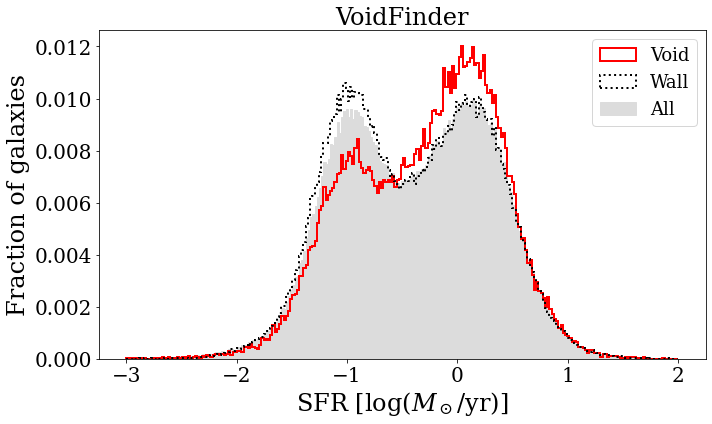

In [15]:
char(SFR,
     np.linspace(-3,2, 250),
     'SFR_hist_VF_NSA',
     'SFR [log($M_\odot$/yr)]', 
     voidfinder = True,
     x=-2.7,
     y=0.012)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


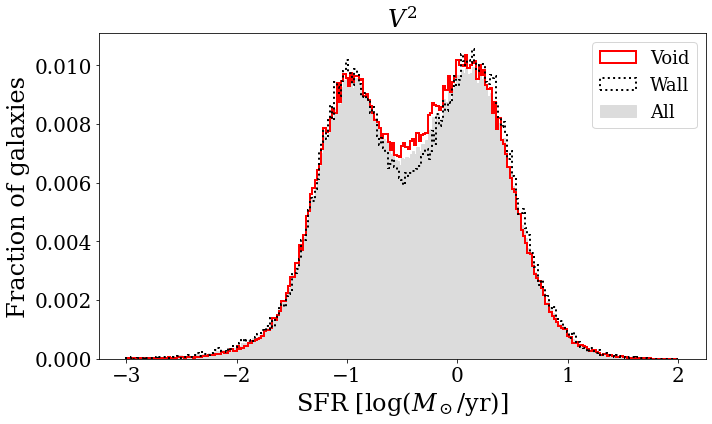

In [16]:
char(SFR,
     np.linspace(-3,2, 250),
     'SFR_hist_V2_NSA',
     'SFR [log($M_\odot$/yr)]',
     x=-2.7,
     y=0.0105)

## Specific Star Formation Rate

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


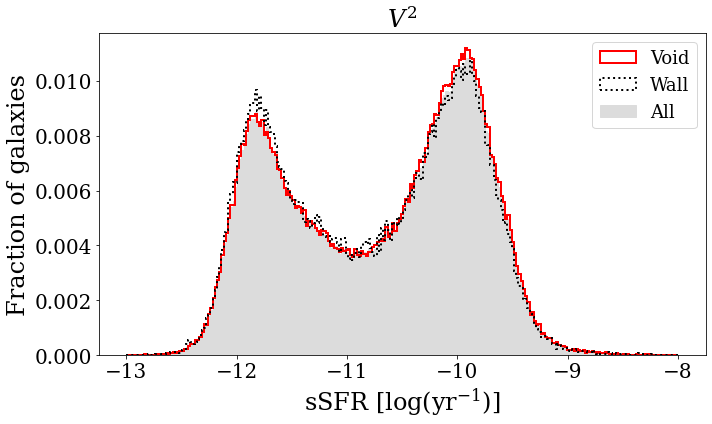

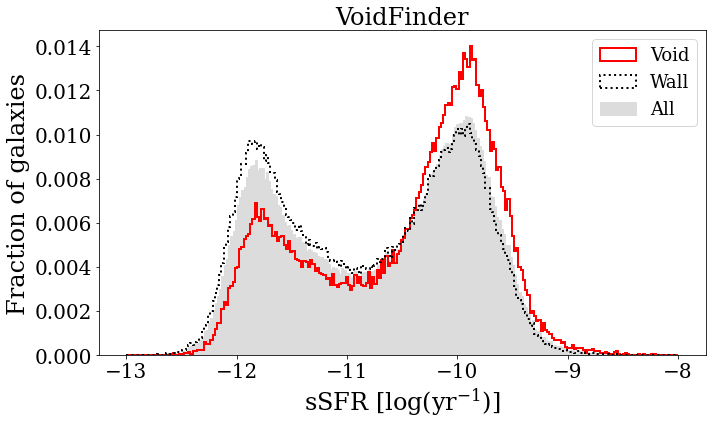

In [17]:
char(sSFR,
     np.linspace(-13,-8, 250),
     'sSFR_hist_VF_NSA',
     'sSFR [log(yr$^{-1}$)]', 
     voidfinder = True,
     x=-12.7,
     y=0.013)

char(sSFR,
     np.linspace(-13,-8, 250),
     'sSFR_hist_V2_NSA',
     'sSFR [log(yr$^{-1}$)]',
     x=-12.7,
     y=0.0105)

# KS tests

We no longer use these in favor of the Beysian analysis.

In [31]:
def KS(char_, void_void=False,void_wall=False,wall_wall=False,voidfinder=False,v2=False):
    '''
    char_: array of galaxy property
    void_void: True if we want to calculate the KS test between two void galaxy samples
    void_wall: True if we want to calculate the KS test between void and wall galaxy samples
    voidfinder : True only if void_wall is True and classification from voidfinder is used
    '''
    #void_wall
    if (void_wall and voidfinder):
        return stats.ks_2samp(char_[wall_vf], char_[void_vf]) 
    if (void_wall and v2):
        return stats.ks_2samp(char_[wall_v2], char_[void_v2]) 
    
    #void_void
    if void_void:
        return stats.ks_2samp(char_[void_vf], char_[void_v2]) 

    # wall_wall
    if wall_wall:
        return stats.ks_2samp(char_[wall_vf], char_[wall_v2]) 



In [35]:
def KS_table(char_):
    '''
    output: two numbers for each cell: kS Test statistic and p-value
    
    diagonals are void_void and wall_wall, row2col1 is void_wall for voidfinder,  and row1col2 is void_wall for V^2
    '''
    a_1_1 = tuple(KS(char_,void_void=True)) #1_1
    a_2_1 = tuple(KS(char_,void_wall=True,voidfinder=True))

    a_1_2 = tuple(KS(char_,void_wall=True,v2=True))
    a_2_2 = tuple(KS(char_,wall_wall=True)) 

    col1=[a_1_1,a_2_1]
    
    col2=[a_1_2,a_2_2]
    

    
    return Table([col1,col2], names=('voidfinder','v_squared'))


In [56]:
print(stats.ks_2samp(Mstar[void_vf], Mstar[wall_v2]) )
print(stats.ks_2samp(u_r[void_vf], u_r[wall_v2]) )
print(stats.ks_2samp(g_r[void_vf], g_r[wall_v2]) )
print(stats.ks_2samp(rabsmag[void_vf], rabsmag[wall_v2]) )
print(stats.ks_2samp(SFR[void_vf], SFR[wall_v2]) )
print(stats.ks_2samp(sSFR[void_vf], sSFR[wall_v2])) 

Ks_2sampResult(statistic=0.09737432984377059, pvalue=9.596518308845177e-277)
Ks_2sampResult(statistic=0.0974511063843424, pvalue=3.517261688586993e-277)
Ks_2sampResult(statistic=0.09735619756826153, pvalue=1.2162194642940036e-276)
Ks_2sampResult(statistic=0.06347187632710183, pvalue=7.88210948369142e-118)
Ks_2sampResult(statistic=0.09303149284014245, pvalue=1.2017203629488489e-252)
Ks_2sampResult(statistic=0.08821650698776451, pvalue=3.253512720093948e-227)


In [59]:
print(stats.ks_2samp(Mstar[wall_v2], Mstar[wall_vf]) )
print(stats.ks_2samp(u_r[wall_v2], u_r[wall_vf]) )
print(stats.ks_2samp(g_r[wall_v2], g_r[wall_vf]) )
print(stats.ks_2samp(rabsmag[wall_v2], rabsmag[wall_vf]) )
print(stats.ks_2samp(SFR[wall_v2], SFR[wall_vf]) )
print(stats.ks_2samp(sSFR[wall_v2], sSFR[wall_vf])) 

Ks_2sampResult(statistic=0.06905365180479675, pvalue=0.0)
Ks_2sampResult(statistic=0.04061800208835664, pvalue=1.0664370213578124e-116)
Ks_2sampResult(statistic=0.04387652575658352, pvalue=4.2065027361769384e-136)
Ks_2sampResult(statistic=0.09127565178886077, pvalue=0.0)
Ks_2sampResult(statistic=0.03518965229369064, pvalue=1.0705447985007178e-87)
Ks_2sampResult(statistic=0.036294646464199665, pvalue=2.9021058099386363e-93)


In [44]:
KS_table(sSFR)

voidfinder [2],v_squared [2]
float64,float64
0.11063584061143517 .. 0.0,0.03529738868550192 .. 1.2314651729235756e-85
0.1204748760652663 .. 0.0,0.036294646464199665 .. 2.9021058099386363e-93


In [774]:
#void-void      void-wall-v2
#void-wall-vf   wall-wall

In [775]:
# decide how to interpret KS test, compare to critical value, p-value? ...

In [776]:
def critical_value(n,m,alpha=0.000000000000000000000000000000000000000001):
    '''
    calculates critical value: if the test statistic is larger than this then the null hypothesis can be rejected 
    at level alpha.
    n: size of sample 1
    m: size of sample 2
    '''
    
    return np.sqrt(-np.log(alpha/2)*(1/2))*np.sqrt((n+m)/(n*m))

In [595]:
critical_value(len(Mstar[wall_vf]),len(Mstar[void_vf])), critical_value(len(Mstar[wall_v2]),len(Mstar[void_v2]))

(0.035894099904138624, 0.02486973838113133)

In [583]:
critical_value(len(Mstar[data['redshift']< 0.1026]),len(Mstar[void_vf])), critical_value(len(Mstar[data['redshift']< 0.1026]),len(Mstar[void_v2]))

(0.006748918330462532, 0.003741446596947954)

In [ ]:
#next: understand hypothesis testing, what does it mean for the hypothesis to be rejected the X% level?
# write statistics paragraph for stellar mass

# Calculate averages and medians

In [20]:
def remove_nan(array):
    '''
    Remove both nan and inf values from array
    '''
    #return array[np.logical_not(np.isnan(array))]
    return array[np.isfinite(array)]

In [40]:
def stats(char_,voidfinder=False):
    '''
    char : array with galaxy properties e.g : Mstar
    voidfinder : true if we want to calculate the statistics of voidfinder data and not V^2 data
    
    note 1 : shifts are taken as void-wall
    note 2: percent difference are calculated with respect to the wall distribution
    
    returns: average, std of average, average shift, std of average shift, percent diff of avg , median, median shift, 
    percent diff of median
    '''
    if voidfinder:
        char_void = remove_nan(char_[void_vf])
        char_wall = remove_nan(char_[wall_vf])
    else:
        char_void = remove_nan(char_[void_v2])
        char_wall = remove_nan(char_[wall_v2])
        
    avg_void = np.mean(char_void)
    avg_wall = np.mean(char_wall)
        
    avg_shift=  avg_wall-avg_void
        
    std_avg_void = np.std(char_void,ddof=1)/np.sqrt(len(char_void))
    std_avg_wall = np.std(char_wall,ddof=1)/np.sqrt(len(char_wall))
    
    std_avg_shift = np.sqrt(std_avg_void**2 + std_avg_wall**2)
        
    percent_diff_avg = (avg_shift/avg_wall)*100
    
    median_wall = np.median(char_wall)
    median_void = np.median(char_void)
    
    median_shift = median_wall-median_void
    
    percent_diff_median = (median_shift/median_wall)*100
    
    print('average void : %0.3f +- %0.3f' %(avg_void, std_avg_void))
    print('average wall :  %0.3f +- %0.3f'%(avg_wall, std_avg_wall))
    print('average shift w.r.t wall :  %0.3f +- %0.3f'%(avg_shift, std_avg_shift))
    print('percent difference in avg w.r.t wall : %0.1f'%(percent_diff_avg))
    print('median void : %0.3f'%(median_void))
    print('median wall : %0.3f'%(median_wall))
    print('median shift w.r.t wall : %0.3f'%(median_shift))
    print('percent difference in median w.r.t wall : %0.1f'%(percent_diff_median))

In [30]:
stats(Mstar_NSA, voidfinder=True)

average void : 9.792 +- 0.002
average wall :  9.991 +- 0.001
average shift w.r.t wall :  0.199 +- 0.002
percent difference in avg w.r.t wall : 2.0
median void : 9.915
median wall : 10.074
median shift w.r.t wall : 0.159
percent difference in median w.r.t wall : 1.6


In [31]:
stats(Mstar_NSA)

average void : 9.910 +- 0.001
average wall :  9.921 +- 0.002
average shift w.r.t wall :  0.012 +- 0.002
percent difference in avg w.r.t wall : 0.1
median void : 10.027
median wall : 10.040
median shift w.r.t wall : 0.013
percent difference in median w.r.t wall : 0.1


In [32]:
stats(rabsmag_NSA, voidfinder=True)

average void : -19.630 +- 0.004
average wall :  -19.976 +- 0.002
average shift w.r.t wall :  -0.345 +- 0.005
percent difference in avg w.r.t wall : 1.7
median void : -19.845
median wall : -20.099
median shift w.r.t wall : -0.254
percent difference in median w.r.t wall : 1.3


In [33]:
stats(rabsmag_NSA)

average void : -19.815 +- 0.003
average wall :  -19.843 +- 0.004
average shift w.r.t wall :  -0.028 +- 0.005
percent difference in avg w.r.t wall : 0.1
median void : -20.021
median wall : -20.048
median shift w.r.t wall : -0.028
percent difference in median w.r.t wall : 0.1


In [34]:
stats(u_r_NSA, voidfinder=True)

average void : 1.965 +- 0.002
average wall :  2.155 +- 0.001
average shift w.r.t wall :  0.190 +- 0.002
percent difference in avg w.r.t wall : 8.8
median void : 1.920
median wall : 2.208
median shift w.r.t wall : 0.288
percent difference in median w.r.t wall : 13.1


In [35]:
stats(u_r_NSA)

average void : 2.100 +- 0.001
average wall :  2.106 +- 0.002
average shift w.r.t wall :  0.006 +- 0.002
percent difference in avg w.r.t wall : 0.3
median void : 2.125
median wall : 2.131
median shift w.r.t wall : 0.006
percent difference in median w.r.t wall : 0.3


In [39]:
stats(g_r_NSA, voidfinder=True)

average void : 0.6298 +- 0.0009
average wall :  0.7044 +- 0.0005
average shift w.r.t wall :  0.0746 +- 0.0010
percent difference in avg w.r.t wall : 10.58
median void : 0.6351
median wall : 0.7501
median shift w.r.t wall : 0.1149
percent difference in median w.r.t wall : 15.32


In [38]:
stats(g_r_NSA)

average void : 0.6833 +- 0.0005
average wall :  0.6861 +- 0.0007
average shift w.r.t wall :  0.0028 +- 0.0009
percent difference in avg w.r.t wall : 0.41
median void : 0.7197
median wall : 0.7235
median shift w.r.t wall : 0.0038
percent difference in median w.r.t wall : 0.53


In [41]:
stats(SFR, voidfinder=True)

average void : -0.302 +- 0.002
average wall :  -0.401 +- 0.001
average shift w.r.t wall :  -0.099 +- 0.003
percent difference in avg w.r.t wall : 24.6
median void : -0.215
median wall : -0.392
median shift w.r.t wall : -0.177
percent difference in median w.r.t wall : 45.1


In [42]:
stats(SFR)

average void : -0.396 +- 0.001
average wall :  -0.389 +- 0.002
average shift w.r.t wall :  0.007 +- 0.003
percent difference in avg w.r.t wall : -1.9
median void : -0.364
median wall : -0.358
median shift w.r.t wall : 0.006
percent difference in median w.r.t wall : -1.7


In [43]:
stats(sSFR, voidfinder=True)

average void : -10.494 +- 0.003
average wall :  -10.783 +- 0.002
average shift w.r.t wall :  -0.289 +- 0.003
percent difference in avg w.r.t wall : 2.7
median void : -10.238
median wall : -10.677
median shift w.r.t wall : -0.439
percent difference in median w.r.t wall : 4.1


In [44]:
stats(sSFR)

average void : -10.710 +- 0.002
average wall :  -10.718 +- 0.003
average shift w.r.t wall :  -0.008 +- 0.003
percent difference in avg w.r.t wall : 0.1
median void : -10.531
median wall : -10.555
median shift w.r.t wall : -0.023
percent difference in median w.r.t wall : 0.2
